In [1]:
# 먼저 텐서플로우 다운받고 mnist 다운받고 준비를 한다.
# 2NN 모델을 설계한다. K는 2~3개 정도만 설정 1Epoch만 돌리고 !!!Weight를 Server로 보낸다.!!! 서버는 W_(t+1)=W_t - g_k    //Fed_SGD,
# 나중에는 클라이언트에서 여러 epoch로 돌리고 Weight를 Server로 보낸다. 서버는 W_(t+1)=W_t - g_k // Fed_AVG
# 당연히 Communication cost는 AVG가 적을 것, AVG가 정확성이 따라올 수 있느냐를 중점으로 확인.
# 가장 먼저 서버모델을 만들고(이니셜라이징), 포문?(확실치 않은 이유가 포문 돌때마다 처음으로 초기화될까봐 겁남.)
# 전체 포문 안에 클라이언트1,2 돌리고 그 2개의 w를 산술평균?(일단 나중에 가중산술평균할겨) 마지막에 서버 모델 w에 덮어씌우고
# 근데 Non-IID 로 MNIST는 어떻게 나누지?

In [2]:
''' 8/29 
    AVG로 구현하기 dd
    1round 마다 server가 클라이언트한테 나눠주기 구현 dd
    2NN말고 CNN으로 구현하기 dd
    MNIST 전부 분류하고 랜덤하게 몇개씩 뽑고 뽑을 때 겹치지 않게
    시각적으로 보이게 히스토그램?
    각 클라이언트들이 에포크 증가할때 정확도가 증가하는지?
    클라이언트가 N개일 때 자동화 어떻게 할 것인지..
    논문에서는 클라이언트가 100이다.
'''


' 8/29 \n    AVG로 구현하기 dd\n    1round 마다 server가 클라이언트한테 나눠주기 구현 dd\n    2NN말고 CNN으로 구현하기 dd\n    MNIST 전부 분류하고 랜덤하게 몇개씩 뽑고 뽑을 때 겹치지 않게\n    시각적으로 보이게 히스토그램?\n    각 클라이언트들이 에포크 증가할때 정확도가 증가하는지?\n    클라이언트가 N개일 때 자동화 어떻게 할 것인지..\n    논문에서는 클라이언트가 100이다.\n'

In [3]:
%pip install matplotlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import os

B_batch=200 # 배치 사이즈
C_epoch=3  # 각 클라이언트마다 몇 에포크 돌릴지
S_round=5  #총 라운드 수
#

#

#

#데이터(MNIST) 전처리
# MNIST 데이터를 불러옵니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 차원 변환 후, 테스트셋과 학습셋으로 나눔
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

##서버 모델 이니셜라이징
# 모델 구조를 설정
'''
'''

server_model = Sequential()
server_model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
server_model.add(Conv2D(64, (5, 5), activation='relu'))
server_model.add(MaxPooling2D(pool_size=(2,2)))
#server_model.add(Dropout(0.25))
server_model.add(Flatten())
server_model.add(Dense(10, activation='softmax'))

#서버 레이어들 정보 요약
server_model.summary()                                                

# 모델 실행 환경을 설정
server_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간
serverpath="./MNIST_MLP_0.hdf5"
checkpointer = ModelCheckpoint(filepath=serverpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# 모델 실행
server_history = server_model.fit(x_train[0:2], y_train[0:2], validation_split=0.25, epochs=1, batch_size=200, verbose=0, callbacks=[early_stopping_callback,checkpointer]) # 최대한 학습 안할려고 2개만 학습시킴...

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 10)                64010     
                                                                 
Total params: 116,106
Trainable params: 116,106
Non-trainable params: 0
__________________________________________________

In [4]:
##클라이언트1 모델 이니셜라이징
# 모델 구조를 설정


client_1_model = Sequential()
client_1_model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
client_1_model.add(Conv2D(64, (5, 5), activation='relu'))
client_1_model.add(MaxPooling2D(pool_size=(2,2)))
#client_1_model.add(Dropout(0.25))
client_1_model.add(Flatten())
client_1_model.add(Dense(10, activation='softmax'))
client_1_model.summary()                                                #서버 레이어들 정보 요약

# 모델 실행 환경을 설정
client_1_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간
client_1path="./MNIST_MLP_1.hdf5"
checkpointer = ModelCheckpoint(filepath=client_1path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

#처음 서버가 클라이언트한테 나눠주는 것
array_temp=server_model.get_weights()
client_1_model.set_weights(array_temp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                64010     
                                                                 
Total params: 116,106
Trainable params: 116,106
Non-trainable params: 0
________________________________________________

In [5]:
##클라이언트2 모델 이니셜라이징
# 모델 구조를 설정
client_2_model = Sequential()
client_2_model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
client_2_model.add(Conv2D(64, (5, 5), activation='relu'))
client_2_model.add(MaxPooling2D(pool_size=(2,2)))
#client_2_model.add(Dropout(0.25))
client_2_model.add(Flatten())
client_2_model.add(Dense(10, activation='softmax'))
client_2_model.summary()    #서버 레이어들 정보 요약

# 모델 실행 환경을 설정
client_2_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간
client_2path="./MNIST_MLP_2.hdf5"
checkpointer = ModelCheckpoint(filepath=client_2path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


#처음 서버가 클라이언트한테 나눠주는 것
array_temp=server_model.get_weights()
client_2_model.set_weights(array_temp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                64010     
                                                                 
Total params: 116,106
Trainable params: 116,106
Non-trainable params: 0
________________________________________________

In [65]:
#클라이언트 w를 산술평균해서 서버 w에 덮어 씌우기.
history_temp=[[],[]]

for i in range(0,S_round):
  #각 클라이언트들마다 computations
  client_1_history = client_1_model.fit(x_train[0:10000], y_train[0:10000], validation_split=0.25, epochs=C_epoch, batch_size=B_batch, verbose=0, callbacks=[early_stopping_callback,checkpointer]) 
  client_2_history = client_2_model.fit(x_train[10000:20000], y_train[10000:20000], validation_split=0.25, epochs=C_epoch, batch_size=B_batch, verbose=0, callbacks=[early_stopping_callback,checkpointer]) 
  
  #각 클라이언트들의 w를 산술평균해서 서버에다가 주는 과정  
  array_temp = []
  for i in range(len(client_1_model.get_weights())):
      array_temp.append((client_1_model.get_weights()[i]+(client_2_model.get_weights())[i])/2.0)
  server_model.set_weights(array_temp)
  
  #1round마다 서버에 모여진 w를 다시 클라이언트한테 주는 것
  array_temp=server_model.get_weights()
  client_1_model.set_weights(array_temp)
  client_2_model.set_weights(array_temp)

  #서버의 1round마다의 데이터들의 히스토리를 모으는 과정
  history_temp[1].append(server_model.evaluate(x_test, y_test)[1])
  print(str(i+1)+"th Test Accuracy: %.4f" % (history_temp[-1][-1]))
  history_temp[0].append(server_model.evaluate(x_train[0:20000], y_train[0:20000])[1])
  print(str(i+1)+"th Train Accuracy: %.4f" % (history_temp[0][-1]))


Epoch 1: val_loss did not improve from 0.13156

Epoch 2: val_loss improved from 0.13156 to 0.10243, saving model to .\MNIST_MLP_2.hdf5

Epoch 3: val_loss did not improve from 0.10243

Epoch 1: val_loss improved from 0.10243 to 0.10061, saving model to .\MNIST_MLP_2.hdf5

Epoch 2: val_loss improved from 0.10061 to 0.08849, saving model to .\MNIST_MLP_2.hdf5

Epoch 3: val_loss did not improve from 0.08849
313/313 [==============================] - 2s 5ms/step - loss: 0.0659 - accuracy: 0.9807
6th Test Accuracy: 0.9807
625/625 [==============================] - 3s 5ms/step - loss: 0.0606 - accuracy: 0.9813
6th Train Accuracy: 0.9813

Epoch 1: val_loss did not improve from 0.08849

Epoch 2: val_loss did not improve from 0.08849

Epoch 3: val_loss did not improve from 0.08849

Epoch 1: val_loss improved from 0.08849 to 0.07844, saving model to .\MNIST_MLP_2.hdf5

Epoch 2: val_loss did not improve from 0.07844

Epoch 3: val_loss improved from 0.07844 to 0.07278, saving model to .\MNIST_MLP_

313/313 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.9848

 Test Accuracy: 0.9848


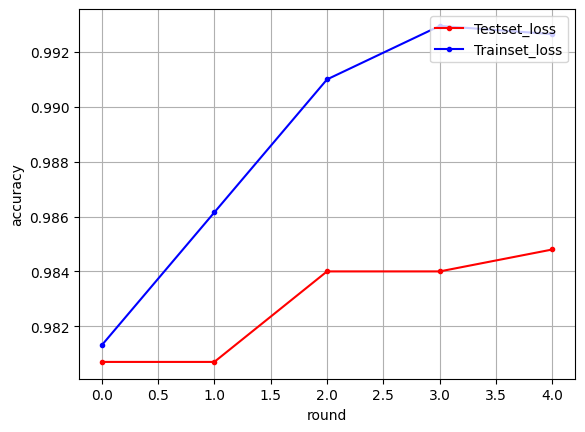

In [66]:
# 테스트 정확도
print("\n Test Accuracy: %.4f" % (server_model.evaluate(x_test, y_test)[1]))
# 검증셋과 학습셋의 오차를 저장
y_vloss = history_temp[1] #server_history.history['val_loss']
y_loss = history_temp[0]  #server_history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드, 레이블
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('round')
plt.ylabel('accuracy')
plt.show()

#keras model에서 가중치(weights) 가져오기

>`Model.get_weights()`

return:모델의 가중치 배열

#Keras model에 가중치(weights) 설정하기
>`Model.set_weights(weights)`

argument:
 - weights : numpy 배열의 가중치

#Keras model의 가중치(weights) 파일로 저장하기
>`Model.save_weights(filepath, overwrite=True)`

arguments:
 - filepath : 저장할 파일 경로, HDF5 형식으로 저장된다.
 - overwrite : 덮어쓰기 여부

#파일에서 Keras model 가중치(weights) 불러와 설정하기
> `Model.load_weights(filepath, by_name=False, skip_mismatch=False, reshpae=False)`

arguments:
 - filepath : 가중치 파일의 경로
 - by_name : 이름 또는 토폴로지 순서로 가중치를 로드 할지 여부를 나타낸다.
 - skip_mismath : 가중치 개수나 모양이 일치하지 않는 레이어를 건너 뛸지에 대한 여부를 나타낸다. (by_name이 True인 경우)
 - reshape : reshape 여부를 나타냄
#다른 사이트
> server_model.layers
> hidden_2 = server_model.layers[1]
> hidden_2.name
> server_model.get_layer('dense_19')
> weights, biases = hidden_2.get_weights()
> print(weights.shape)
> print(biases.shape)
> print(weights)
>print(biases)


In [ ]:
idx = np.argsort(y_train) #idx는 
temp_yval=[]
for i in range(len(idx)):
    temp_yval.append(idx[i][9])

idx = np.argsort(temp_yval)

x_train_sorted = x_train[idx]
y_train_sorted = y_train[idx]
yval_sorted = np.array(temp_yval)[idx]

sorted_x_train=[]
#sorted_x_train=np.array(sorted_x_train)
for i in range(10):
    sorted_x_train.append(x_train_sorted[yval_sorted == i])

'''
print("0 :",len(sorted_x_train[0]),"1 :",len(sorted_x_train[1]),"2 :",len(sorted_x_train[2]),"3 :",len(sorted_x_train[3]),"4 :",len(sorted_x_train[4]),"5 :",len(sorted_x_train[5]),
"6 :",len(sorted_x_train[6]),"7 :",len(sorted_x_train[7]),"8 :",len(sorted_x_train[8]),"9 :",len(sorted_x_train[9]))

print(x_train_sorted[yval_sorted == 0].shape)
'''


In [ ]:
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)
print("idx.shape: ",idx.shape)